<a href="https://colab.research.google.com/github/theerapatxx13/MINIProject-House-Price/blob/main/FinalMiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()  # อัปโหลดไฟล์
filename = list(uploaded.keys())[0]  # ดึงชื่อไฟล์

Saving house_prices.csv to house_prices.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. โหลดไฟล์ CSV เข้าเป็น DataFrame (Import Dataset)
df = pd.read_csv('house_prices.csv')

# ตรวจสอบข้อมูล
print(f"จำนวนข้อมูลทั้งหมด: {df.shape[0]} แถว, {df.shape[1]} คอลัมน์")
print(df.head())

# 2. Data Cleaning
# ตรวจ Missing Values
missing_values = df.isnull().sum()

# ฟังชันก์นี้ แปลงข้อมูลราคาในคอลัมน์ amount เช่น "45 Lac" → 4,500,000
def clean_amount(x):
    if pd.isna(x): return np.nan
    x = str(x).lower().replace('inr', '').replace(',', '').strip()
    try:
        val = float(re.findall(r"[-+]?\d*\.\d+|\d+", x)[0])
        if 'lac' in x: return val * 100000
        if 'cr' in x: return val * 10000000
        return val
    except: return np.nan

# แปลงคอลัมน์ Area เพราะเก็บค่าพื้นที่เป็น string เช่น "1200 sqft" จะถูกแปลงให้เป็น 1200.0
def clean_area(x):
    if pd.isna(x): return np.nan
    try:
        return float(re.findall(r"[-+]?\d*\.\d+|\d+", str(x))[0])
    except: return np.nan

df['Price_Total'] = df['Amount(in rupees)'].apply(clean_amount)
df['Area'] = df['Carpet Area'].apply(clean_area).fillna(df['Super Area'].apply(clean_area))

# ลบคอลัมน์ที่ไม่ใช้ หรือเป็น text ยาว ไม่ช่วยทำนายราคา
df = df.drop(columns=['Dimensions', 'Plot Area', 'Index', 'Description', 'Title', 'Society', 'Car Parking', 'Ownership', 'overlooking', 'facing'])

# ทำความสะอาด numeric counts
def extract_num(x):
    if pd.isna(x): return 0
    res = re.findall(r"\d+", str(x))
    return int(res[0]) if res else 0

df['Bathroom'] = df['Bathroom'].apply(extract_num)
df['Balcony'] = df['Balcony'].apply(extract_num)

# ลบข้อมูลแถวในคอลัมน์ของ price_total, area ที่เป็น null เพื่อที่จะไปทำนาย
df = df.dropna(subset=['Price_Total', 'Area'])

# เติมค่า Missing ของ categorical ด้วย mode
for col in ['location', 'Status', 'Floor', 'Transaction', 'Furnishing']:
    df[col] = df[col].fillna(df[col].mode()[0])

# จัดการ Outliers (Outlier Detection)
q_p = df['Price_Total'].quantile(0.99)
q_a = df['Area'].quantile(0.99)
df_clean = df[(df['Price_Total'] <= q_p) & (df['Area'] <= q_a)].copy()

print("Missing values Before:\n", missing_values)
print("\nMissing values AFTER cleaning:\n", df_clean.isnull().sum())

#แสดงผลก่อน Outlier
outlier_before = pd.Series({
    'Price': (df['Price_Total'] > q_p).sum(),
    'Area' : (df['Area'] > q_a).sum()
})

print("\nOutliers before:")
print(outlier_before)

#แสดงผลหลัง Outlier
outlier_after = pd.Series({
    'Price': (df_clean['Price_Total'] > q_p).sum(),
    'Area' : (df_clean['Area'] > q_a).sum()
})
print("\nOutliers after:")
print(outlier_after)

จำนวนข้อมูลทั้งหมด: 187531 แถว, 21 คอลัมน์
   Index                                              Title  \
0      0  1 BHK Ready to Occupy Flat for sale in Srushti...   
1      1  2 BHK Ready to Occupy Flat for sale in Dosti V...   
2      2  2 BHK Ready to Occupy Flat for sale in Sunrise...   
3      3        1 BHK Ready to Occupy Flat for sale Kasheli   
4      4  2 BHK Ready to Occupy Flat for sale in TenX Ha...   

                                         Description Amount(in rupees)  \
0  Bhiwandi, Thane has an attractive 1 BHK Flat f...           42 Lac    
1  One can find this stunning 2 BHK flat for sale...           98 Lac    
2  Up for immediate sale is a 2 BHK apartment in ...          1.40 Cr    
3  This beautiful 1 BHK Flat is available for sal...           25 Lac    
4  This lovely 2 BHK Flat in Pokhran Road, Thane ...          1.60 Cr    

   Price (in rupees) location Carpet Area         Status         Floor  \
0             6000.0    thane    500 sqft  Ready to Move  1

In [ ]:
print("--- สรุปขั้นตอนที่ 1: การนำเข้าและสำรวจข้อมูลเบื้องต้น ---")
print("1. ทำการโหลดไฟล์ 'house_prices.csv' เข้าสู่ระบบเพื่อเตรียมประมวลผล")
print("2. ตรวจสอบมิติของข้อมูลว่ามีทั้งหมดกี่แถวและกี่คอลัมน์เพื่อให้เห็นขนาดของงาน")
print("3. เช็กค่าว่าง (Missing Values) ในทุกคอลัมน์เพื่อวางแผนการซ่อมแซมข้อมูล")

print("\n--- สรุปขั้นตอนที่ 2: การชำระล้างข้อมูลเชิงลึก (Data Cleaning) ---")
print("1. การแปลงหน่วยเงิน (Currency Conversion):")
print("   - สร้างฟังก์ชันเปลี่ยนหน่วย 'Lac' (แสน) และ 'Cr' (สิบล้าน) ให้เป็นตัวเลขจำนวนเต็ม")
print("   - ใช้ Regex เพื่อดึงเฉพาะตัวเลขออกจากข้อความ เพื่อให้คอมพิวเตอร์คำนวณได้")

print("2. การจัดการข้อมูลพื้นที่ (Area Standardization):")
print("   - รวมคอลัมน์ Carpet Area และ Super Area เข้าด้วยกันเพื่อไม่ให้ข้อมูลแหว่ง")
print("   - ลบหน่วยวัดที่เป็นตัวอักษรออก (เช่น sqft) ให้เหลือเพียงตัวเลขทศนิยม")

print("3. การคัดกรองฟีเจอร์ (Feature Selection):")
print("   - ลบคอลัมน์ที่เป็นข้อความยาวๆ หรือข้อมูลที่ไม่มีผลต่อราคา เช่น รายละเอียดบ้าน, ทิศที่หันหน้า, หรือที่จอดรถ")
print("   - เป้าหมายคือการลด 'Noise' เพื่อให้โมเดลโฟกัสเฉพาะปัจจัยสำคัญจริงๆ")

print("4. การซ่อมแซมและจัดการข้อมูลที่หายไป (Imputation):")
print("   - ดึงจำนวนห้องน้ำและระเบียงออกมาเป็นตัวเลข")
print("   - ลบแถวที่ไม่มีราคาหรือพื้นที่ทิ้งทันที เพราะเป็นข้อมูลที่นำไปสอนโมเดลไม่ได้")
print("   - สำหรับข้อมูลหมวดหมู่ (เช่น ทำเล, สถานะการตกแต่ง) ที่หายไป ให้เติมด้วยค่าที่ปรากฏบ่อยที่สุด (Mode)")

print("5. การจัดการข้อมูลที่สูงผิดปกติ (Outlier Handling):")
print("   - ใช้เกณฑ์เปอร์เซ็นไทล์ที่ 99 (99th Percentile) เพื่อตัดบ้านที่ราคาแพงเวอร์หรือพื้นที่กว้างผิดปกติออก")
print("   - ขั้นตอนนี้สำคัญมาก เพราะ Outlier เพียงไม่กี่จุดอาจทำให้โมเดลพยากรณ์เพี้ยนไปทั้งระบบ")

--- สรุปขั้นตอนที่ 1: การนำเข้าและสำรวจข้อมูลเบื้องต้น ---
1. ทำการโหลดไฟล์ 'house_prices.csv' เข้าสู่ระบบเพื่อเตรียมประมวลผล
2. ตรวจสอบมิติของข้อมูลว่ามีทั้งหมดกี่แถวและกี่คอลัมน์เพื่อให้เห็นขนาดของงาน
3. เช็กค่าว่าง (Missing Values) ในทุกคอลัมน์เพื่อวางแผนการซ่อมแซมข้อมูล

--- สรุปขั้นตอนที่ 2: การชำระล้างข้อมูลเชิงลึก (Data Cleaning) ---
1. การแปลงหน่วยเงิน (Currency Conversion):
   - สร้างฟังก์ชันเปลี่ยนหน่วย 'Lac' (แสน) และ 'Cr' (สิบล้าน) ให้เป็นตัวเลขจำนวนเต็ม
   - ใช้ Regex เพื่อดึงเฉพาะตัวเลขออกจากข้อความ เพื่อให้คอมพิวเตอร์คำนวณได้
2. การจัดการข้อมูลพื้นที่ (Area Standardization):
   - รวมคอลัมน์ Carpet Area และ Super Area เข้าด้วยกันเพื่อไม่ให้ข้อมูลแหว่ง
   - ลบหน่วยวัดที่เป็นตัวอักษรออก (เช่น sqft) ให้เหลือเพียงตัวเลขทศนิยม
3. การคัดกรองฟีเจอร์ (Feature Selection):
   - ลบคอลัมน์ที่เป็นข้อความยาวๆ หรือข้อมูลที่ไม่มีผลต่อราคา เช่น รายละเอียดบ้าน, ทิศที่หันหน้า, หรือที่จอดรถ
   - เป้าหมายคือการลด 'Noise' เพื่อให้โมเดลโฟกัสเฉพาะปัจจัยสำคัญจริงๆ
4. การซ่อมแซมและจัดการข้อมูลที่ห

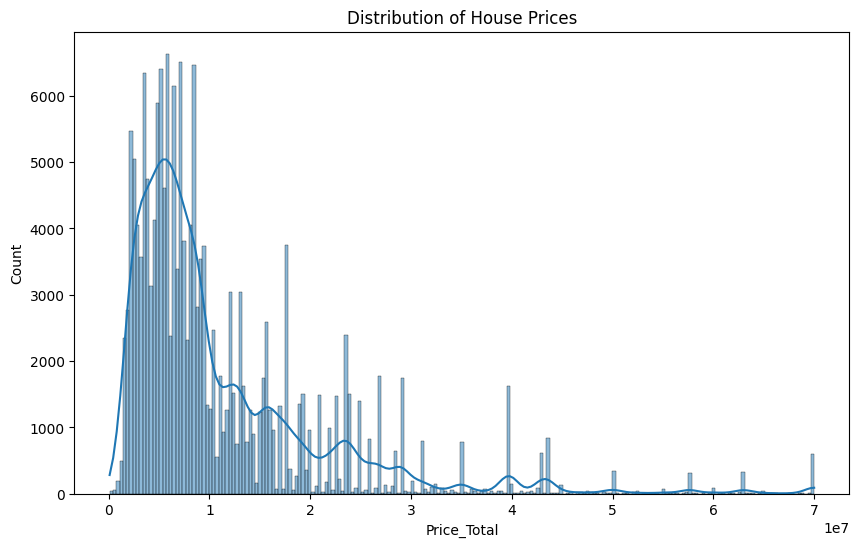

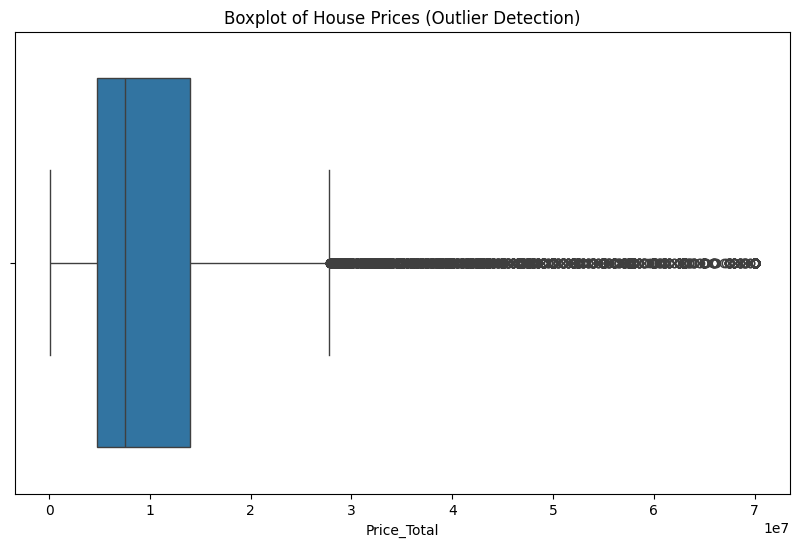

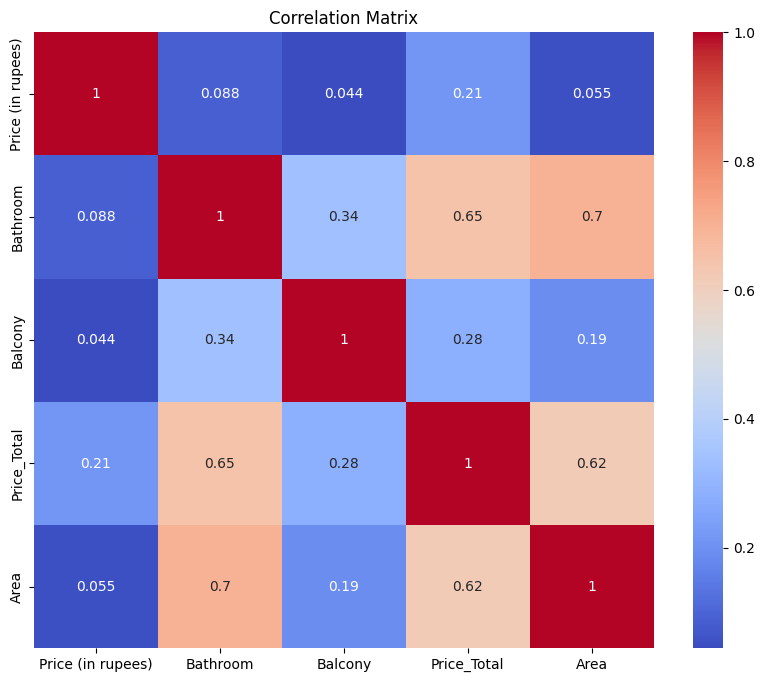

In [ ]:
# 3. EDA
desc_stats = df_clean.describe()

# Plot 1: Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Price_Total'], kde=True)
plt.title('Distribution of House Prices')
plt.savefig('price_dist.png')

# Plot 2: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('corr_matrix.png')

# Plot 3: Boxplot for Outlier Detection (Price)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['Price_Total'])
plt.title('Boxplot of House Prices (Outlier Detection)')
plt.savefig('price_outlier_boxplot.png')
plt.show()

# Preprocessing for Modeling
# แปลง categorical ให้เป็นตัวเลข เพราะโมเดลรับได้แค่ตัวเลข (Label Encoding for categoricals)
le = LabelEncoder()
cat_cols = ['location', 'Status', 'Floor', 'Transaction', 'Furnishing']
for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

In [ ]:
print("--- สรุปการอ่านกราฟวิเคราะห์ข้อมูล (EDA Insight) ---")

print("1. กราฟ Distribution of House Prices (การกระจายตัวของราคา):")
print("   - วิธีอ่าน: กราฟเบ้ขวา (Right-Skewed) อย่างชัดเจน หมายความว่าบ้านส่วนใหญ่ราคากองอยู่ฝั่งถูก")
print("   - ข้อสังเกต: มี 'หาง' ยาวไปทางขวา คือบ้านราคาแพงพิเศษที่มีจำนวนน้อยแต่ดึงค่าเฉลี่ยให้สูงขึ้น")
print("   - แอคชั่น: อาจต้องพิจารณาทำ Log Transformation เพื่อให้ข้อมูลกระจายตัวแบบปกติ (Normal Distribution) มากขึ้น")

print("2. กราฟ Boxplot of House Prices (การตรวจจับข้อมูลผิดปกติ):")
print("   - วิธีอ่าน: ขีดกลางในกล่องคือค่ามัธยฐาน (Median) ส่วน 'จุดไข่ปลา' ทางขวาคือ Outliers")
print("   - ข้อสังเกต: มีจุดเยอะมากในช่วงราคาเกิน 30 ล้านขึ้นไป ซึ่งเป็นกลุ่มที่พยากรณ์ยากที่สุด")
print("   - แอคชั่น: ต้องตัดสินใจว่าจะลบออกเพื่อให้โมเดลแม่นยำขึ้น หรือจะเก็บไว้ถ้าต้องการให้โมเดลรู้จักบ้านราคาแพงด้วย")

print("3. กราฟ Correlation Matrix (ความสัมพันธ์ระหว่างตัวแปร):")
print("   - วิธีอ่าน: ตัวเลขยิ่งเข้าใกล้ 1.0 (สีแดงเข้ม) แปลว่าสัมพันธ์กันสูง ถ้าค่าหนึ่งขึ้น อีกค่าจะขึ้นตาม")
print("   - ข้อสังเกต: 'Bathroom' (0.65) และ 'Area' (0.62) มีความสัมพันธ์กับ 'Price_Total' สูงที่สุด")
print("   - ข้อควรระวัง: 'Area' กับ 'Bathroom' สัมพันธ์กันเองสูง (0.7) อาจเกิดปัญหาข้อมูลซ้ำซ้อน (Multicollinearity)")

print("4. ขั้นตอน Preprocessing (การเตรียมข้อมูลตัวอักษร):")
print("   - ทำไมต้องทำ: เพราะคอมพิวเตอร์คำนวณ 'Location' เป็นตัวหนังสือไม่ได้")
print("   - วิธีการ: ใช้ Label Encoding เปลี่ยนชื่อสถานที่หรือสถานะให้เป็นตัวเลข (0, 1, 2, ...)")
print("   - ผลลัพธ์: ทำให้โมเดลสามารถนำ 'ทำเล' หรือ 'การตกแต่ง' ไปคำนวณเป็นน้ำหนักคะแนนได้")

--- สรุปการอ่านกราฟวิเคราะห์ข้อมูล (EDA Insight) ---
1. กราฟ Distribution of House Prices (การกระจายตัวของราคา):
   - วิธีอ่าน: กราฟเบ้ขวา (Right-Skewed) อย่างชัดเจน หมายความว่าบ้านส่วนใหญ่ราคากองอยู่ฝั่งถูก
   - ข้อสังเกต: มี 'หาง' ยาวไปทางขวา คือบ้านราคาแพงพิเศษที่มีจำนวนน้อยแต่ดึงค่าเฉลี่ยให้สูงขึ้น
   - แอคชั่น: อาจต้องพิจารณาทำ Log Transformation เพื่อให้ข้อมูลกระจายตัวแบบปกติ (Normal Distribution) มากขึ้น
2. กราฟ Boxplot of House Prices (การตรวจจับข้อมูลผิดปกติ):
   - วิธีอ่าน: ขีดกลางในกล่องคือค่ามัธยฐาน (Median) ส่วน 'จุดไข่ปลา' ทางขวาคือ Outliers
   - ข้อสังเกต: มีจุดเยอะมากในช่วงราคาเกิน 30 ล้านขึ้นไป ซึ่งเป็นกลุ่มที่พยากรณ์ยากที่สุด
   - แอคชั่น: ต้องตัดสินใจว่าจะลบออกเพื่อให้โมเดลแม่นยำขึ้น หรือจะเก็บไว้ถ้าต้องการให้โมเดลรู้จักบ้านราคาแพงด้วย
3. กราฟ Correlation Matrix (ความสัมพันธ์ระหว่างตัวแปร):
   - วิธีอ่าน: ตัวเลขยิ่งเข้าใกล้ 1.0 (สีแดงเข้ม) แปลว่าสัมพันธ์กันสูง ถ้าค่าหนึ่งขึ้น อีกค่าจะขึ้นตาม
   - ข้อสังเกต: 'Bathroom' (0.65) และ 'Area' (0.62) มีความสัมพันธ์กับ 'Price

In [ ]:
# --- สรุปผลการวิเคราะห์เชิงสำรวจ (EDA Insights Summary) ---

print("="*70)
print(" สรุปเชิงลึกจากกราฟ EDA (Exploratory Data Analysis)")
print("="*70)

print("\n1. [Price Distribution Analysis] - จากกราฟ Histogram")
print("-" * 50)
print("   - ข้อมูลมีการกระจายตัวแบบ 'เบ้ขวา' (Right-Skewed Distribution) อย่างชัดเจน")
print("   - บ้านส่วนใหญ่ (Mass Market) กระุกตัวอยู่ที่ราคาต่ำกว่า 10 ล้านรูปี")
print("   - มีกลุ่มบ้านหรู (Luxury) ที่ลากหางกราฟยาวไปจนถึง 70 ล้านรูปี")
print("   -  คำแนะนำ: อาจพิจารณาทำ Log Transformation ที่ตัวแปรเป้าหมาย (Price) เพื่อให้โมเดลเรียนรู้ได้ดีขึ้น")

print("\n2. [Outlier Detection] - จากกราฟ Boxplot")
print("-" * 50)
print("   - พบ Outliers จำนวนมากหลังจากช่วง 28 ล้านรูปี เป็นต้นไป")
print("   - แม้จะตัดที่ Percentile 99 แล้ว แต่ข้อมูลอสังหาฯ มักมีความต่างของราคาสูง (Variance)")
print("   -  คำแนะนำ: การใช้โมเดล Robust อย่าง Random Forest จะรับมือกับจุดเหล่านี้ได้ดีกว่า Linear Regression")

print("\n3. [Feature Correlation] - จาก Heatmap Matrix")
print("-" * 50)
print(f"   - {'[Bathroom]':<15}: สัมพันธ์กับราคา 'สูงที่สุด' (0.65)")
print(f"   - {'[Area]':<15}: สัมพันธ์กับราคา 'สูงรองลงมา' (0.62)")
print(f"   - {'[Multicollinearity]':<15}: Bathroom กับ Area มีความสัมพันธ์กันเองสูง (0.70)")
print("   - [Validation Check]: Correlation ของ Price (ก่อน Clean) กับ Price_Total (หลัง Clean)")
print("     อยู่ที่เพียง 0.21 แสดงว่าการทำ Data Cleaning 'จำเป็นอย่างยิ่ง' และได้ผลดีมาก")

print("\n" + "="*70)
print(" สรุปสถานะข้อมูล: พร้อมส่งเข้าสู่การ Train Model")
print("   ฟีเจอร์เด่นที่จะขับเคลื่อนราคาคือ: Area และ Bathroom")
print("="*70)

 สรุปเชิงลึกจากกราฟ EDA (Exploratory Data Analysis)

1. [Price Distribution Analysis] - จากกราฟ Histogram
--------------------------------------------------
   - ข้อมูลมีการกระจายตัวแบบ 'เบ้ขวา' (Right-Skewed Distribution) อย่างชัดเจน
   - บ้านส่วนใหญ่ (Mass Market) กระุกตัวอยู่ที่ราคาต่ำกว่า 10 ล้านรูปี
   - มีกลุ่มบ้านหรู (Luxury) ที่ลากหางกราฟยาวไปจนถึง 70 ล้านรูปี
   -  คำแนะนำ: อาจพิจารณาทำ Log Transformation ที่ตัวแปรเป้าหมาย (Price) เพื่อให้โมเดลเรียนรู้ได้ดีขึ้น

2. [Outlier Detection] - จากกราฟ Boxplot
--------------------------------------------------
   - พบ Outliers จำนวนมากหลังจากช่วง 28 ล้านรูปี เป็นต้นไป
   - แม้จะตัดที่ Percentile 99 แล้ว แต่ข้อมูลอสังหาฯ มักมีความต่างของราคาสูง (Variance)
   -  คำแนะนำ: การใช้โมเดล Robust อย่าง Random Forest จะรับมือกับจุดเหล่านี้ได้ดีกว่า Linear Regression

3. [Feature Correlation] - จาก Heatmap Matrix
--------------------------------------------------
   - [Bathroom]     : สัมพันธ์กับราคา 'สูงที่สุด' (0.65)
   - [Area]         : สัมพ

In [ ]:
# 4. แยก X, y และกำหนด Train Test Split เป็น 80/20
X = df_clean.drop(columns=['Price_Total', 'Amount(in rupees)', 'Price (in rupees)', 'Carpet Area', 'Super Area'])
y = df_clean['Price_Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("--- สรุปขั้นตอนการเตรียมข้อมูลสำหรับการสร้างโมเดล ---")

print("1. การเตรียม Features (X): เราทำการดึงข้อมูลที่เป็น 'ปัจจัย' ในการทำนายออกมา")
print("   - โดยการลบคอลัมน์ที่เป็นราคา (Price) และข้อมูลพื้นที่ (Area) ที่ซ้ำซ้อนออก")
print("   - เพื่อป้องกันปัญหา Data Leakage (การที่โมเดลแอบเห็นคำตอบล่วงหน้าจากตัวแปรอื่น)")

print("2. การเตรียม Target (y): เรากำหนดให้คอลัมน์ 'Price_Total' เป็น 'เป้าหมาย'")
print("   - นี่คือค่าที่เราต้องการให้โมเดลหัดพยากรณ์ให้แม่นยำที่สุด")

print("3. การทำ Train/Test Split (80/20):")
print("   - แบ่งข้อมูล 80% (Train Set) ไว้ให้โมเดลใช้เรียนรู้และจดจำรูปแบบ")
print("   - แบ่งข้อมูล 20% (Test Set) เก็บไว้เป็น 'ข้อสอบ' เพื่อวัดผลว่าโมเดลทำนายได้แม่นยำจริงไหมกับข้อมูลที่ไม่เคยเห็น")

print("4. การกำหนด Random State = 42:")
print("   - เป็นการล็อกการสุ่ม เพื่อให้การรันโค้ดทุกครั้งได้การแบ่งข้อมูลที่เหมือนเดิม")
print("   - ช่วยให้เราเปรียบเทียบประสิทธิภาพของโมเดลแต่ละตัวได้อย่างเป็นธรรม (Reproducibility)")

--- สรุปขั้นตอนการเตรียมข้อมูลสำหรับการสร้างโมเดล ---
1. การเตรียม Features (X): เราทำการดึงข้อมูลที่เป็น 'ปัจจัย' ในการทำนายออกมา
   - โดยการลบคอลัมน์ที่เป็นราคา (Price) และข้อมูลพื้นที่ (Area) ที่ซ้ำซ้อนออก
   - เพื่อป้องกันปัญหา Data Leakage (การที่โมเดลแอบเห็นคำตอบล่วงหน้าจากตัวแปรอื่น)
2. การเตรียม Target (y): เรากำหนดให้คอลัมน์ 'Price_Total' เป็น 'เป้าหมาย'
   - นี่คือค่าที่เราต้องการให้โมเดลหัดพยากรณ์ให้แม่นยำที่สุด
3. การทำ Train/Test Split (80/20):
   - แบ่งข้อมูล 80% (Train Set) ไว้ให้โมเดลใช้เรียนรู้และจดจำรูปแบบ
   - แบ่งข้อมูล 20% (Test Set) เก็บไว้เป็น 'ข้อสอบ' เพื่อวัดผลว่าโมเดลทำนายได้แม่นยำจริงไหมกับข้อมูลที่ไม่เคยเห็น
4. การกำหนด Random State = 42:
   - เป็นการล็อกการสุ่ม เพื่อให้การรันโค้ดทุกครั้งได้การแบ่งข้อมูลที่เหมือนเดิม
   - ช่วยให้เราเปรียบเทียบประสิทธิภาพของโมเดลแต่ละตัวได้อย่างเป็นธรรม (Reproducibility)


In [ ]:
# 5. เทรนโมเดล (Training Models)
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

# ทำนายแต่ละโมเดล (Predictions)
y_pred_lr = lr.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [ ]:
print("--- สรุปขั้นตอนการเทรนโมเดลและการพยากรณ์ ---")

print("1. การเลือกอาวุธ (Model Selection):")
print("   - Linear Regression: เป็นโมเดลพื้นฐานที่เน้นหาความสัมพันธ์เป็นเส้นตรง")
print("   - Ridge Regression: พัฒนาจากตัวแรก โดยมีการใส่ตัวแปรควบคุม (Alpha) เพื่อป้องกันโมเดล 'จำแม่นเกินไป' จนใช้จริงไม่ได้ (Overfitting)")
print("   - Random Forest Regressor: ตัวท็อปสาย Ensemble ที่ใช้การรวมพลังของต้นไม้ตัดสินใจ 100 ต้น มาช่วยกันหาคำตอบ")

print("2. การเรียนรู้ (Training/Fitting):")
print("   - ใช้คำสั่ง .fit(X_train, y_train) เพื่อให้ทั้ง 3 โมเดลเข้าไปศึกษาข้อมูล 80% ที่เราเตรียมไว้")
print("   - ขั้นตอนนี้โมเดลจะพยายามหา 'สูตรลับ' เพื่อเชื่อมโยงปัจจัยต่างๆ เข้ากับราคาบ้าน")

print("3. การลองทำข้อสอบ (Prediction):")
print("   - ใช้คำสั่ง .predict(X_test) โดยส่งเฉพาะ 'ปัจจัย' (X_test) เข้าไปให้โมเดลทำนายราคา")
print("   - ผลลัพธ์ที่ได้ (y_pred) คือราคาที่โมเดล 'เดา' ออกมา ซึ่งเราจะเอาไปเทียบกับราคาจริงในขั้นตอนถัดไป")

--- สรุปขั้นตอนการเทรนโมเดลและการพยากรณ์ ---
1. การเลือกอาวุธ (Model Selection):
   - Linear Regression: เป็นโมเดลพื้นฐานที่เน้นหาความสัมพันธ์เป็นเส้นตรง
   - Ridge Regression: พัฒนาจากตัวแรก โดยมีการใส่ตัวแปรควบคุม (Alpha) เพื่อป้องกันโมเดล 'จำแม่นเกินไป' จนใช้จริงไม่ได้ (Overfitting)
   - Random Forest Regressor: ตัวท็อปสาย Ensemble ที่ใช้การรวมพลังของต้นไม้ตัดสินใจ 100 ต้น มาช่วยกันหาคำตอบ
2. การเรียนรู้ (Training/Fitting):
   - ใช้คำสั่ง .fit(X_train, y_train) เพื่อให้ทั้ง 3 โมเดลเข้าไปศึกษาข้อมูล 80% ที่เราเตรียมไว้
   - ขั้นตอนนี้โมเดลจะพยายามหา 'สูตรลับ' เพื่อเชื่อมโยงปัจจัยต่างๆ เข้ากับราคาบ้าน
3. การลองทำข้อสอบ (Prediction):
   - ใช้คำสั่ง .predict(X_test) โดยส่งเฉพาะ 'ปัจจัย' (X_test) เข้าไปให้โมเดลทำนายราคา
   - ผลลัพธ์ที่ได้ (y_pred) คือราคาที่โมเดล 'เดา' ออกมา ซึ่งเราจะเอาไปเทียบกับราคาจริงในขั้นตอนถัดไป


In [ ]:
# 6. Evaluation ด้วย Metric R2, MAE, RMSE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "Linear Regression": y_pred_lr,
    "Ridge Regression": y_pred_ridge,
    "Random Forest": y_pred_rf
}

results = []

for name, preds in models.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append([name, r2, mae, rmse])

results_df = pd.DataFrame(results, columns=["Model", "R2", "MAE", "RMSE"])

print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
               Model        R2           MAE          RMSE
0  Linear Regression  0.487802  4.951600e+06  7.191638e+06
1   Ridge Regression  0.487802  4.951595e+06  7.191638e+06
2      Random Forest  0.932344  9.114506e+05  2.613737e+06


In [ ]:
print("--- สรุปขั้นตอนการวัดผลประสิทธิภาพของโมเดล (Evaluation) ---")

print("1. การเตรียมไม้บรรทัด (Metrics Selection):")
print("   - R2 Score (R-squared): 'ความแม่นยำในภาพรวม' ยิ่งเข้าใกล้ 1.0 แปลว่าโมเดลอธิบายข้อมูลได้ดีมาก")
print("   - MAE (Mean Absolute Error): 'ค่าความคลาดเคลื่อนเฉลี่ย' บอกว่าโดยเฉลี่ยแล้วโมเดลทายราคาผิดไปกี่บาท (ดูง่ายที่สุด)")
print("   - RMSE (Root Mean Squared Error): 'ค่าความคลาดเคลื่อนแบบทำโทษตัวที่ทายผิดเยอะๆ' ถ้าค่านี้สูง แปลว่ามีบางเคสที่โมเดลทายพลาดไปไกลมาก")

print("2. กระบวนการคำนวณ (Looping & Calculation):")
print("   - นำค่าจริง (y_test) มาเปรียบเทียบกับค่าที่แต่ละโมเดลทายไว้ (y_pred)")
print("   - วนลูปเก็บผลลัพธ์ของ Linear, Ridge และ Random Forest ไว้ในรายการเดียวกัน")

print("3. การสรุปผล (Results Consolidation):")
print("   - นำตัวเลขทั้งหมดมาจัดลงในรูปแบบตาราง (DataFrame) เพื่อให้เปรียบเทียบกันได้ชัดๆ")
print("   - ช่วยให้ตัดสินใจได้ทันทีว่า 'Random Forest' หรือ 'Linear' ตัวไหนคือผู้ชนะในศึกครั้งนี้")

print("4. การอ่านผลลัพธ์:")
print("   - โมเดลที่ดีที่สุดคือตัวที่มีค่า R2 สูงที่สุด และมีค่า MAE/RMSE ต่ำที่สุดครับ")

--- สรุปขั้นตอนการวัดผลประสิทธิภาพของโมเดล (Evaluation) ---
1. การเตรียมไม้บรรทัด (Metrics Selection):
   - R2 Score (R-squared): 'ความแม่นยำในภาพรวม' ยิ่งเข้าใกล้ 1.0 แปลว่าโมเดลอธิบายข้อมูลได้ดีมาก
   - MAE (Mean Absolute Error): 'ค่าความคลาดเคลื่อนเฉลี่ย' บอกว่าโดยเฉลี่ยแล้วโมเดลทายราคาผิดไปกี่บาท (ดูง่ายที่สุด)
   - RMSE (Root Mean Squared Error): 'ค่าความคลาดเคลื่อนแบบทำโทษตัวที่ทายผิดเยอะๆ' ถ้าค่านี้สูง แปลว่ามีบางเคสที่โมเดลทายพลาดไปไกลมาก
2. กระบวนการคำนวณ (Looping & Calculation):
   - นำค่าจริง (y_test) มาเปรียบเทียบกับค่าที่แต่ละโมเดลทายไว้ (y_pred)
   - วนลูปเก็บผลลัพธ์ของ Linear, Ridge และ Random Forest ไว้ในรายการเดียวกัน
3. การสรุปผล (Results Consolidation):
   - นำตัวเลขทั้งหมดมาจัดลงในรูปแบบตาราง (DataFrame) เพื่อให้เปรียบเทียบกันได้ชัดๆ
   - ช่วยให้ตัดสินใจได้ทันทีว่า 'Random Forest' หรือ 'Linear' ตัวไหนคือผู้ชนะในศึกครั้งนี้
4. การอ่านผลลัพธ์:
   - โมเดลที่ดีที่สุดคือตัวที่มีค่า R2 สูงที่สุด และมีค่า MAE/RMSE ต่ำที่สุดครับ


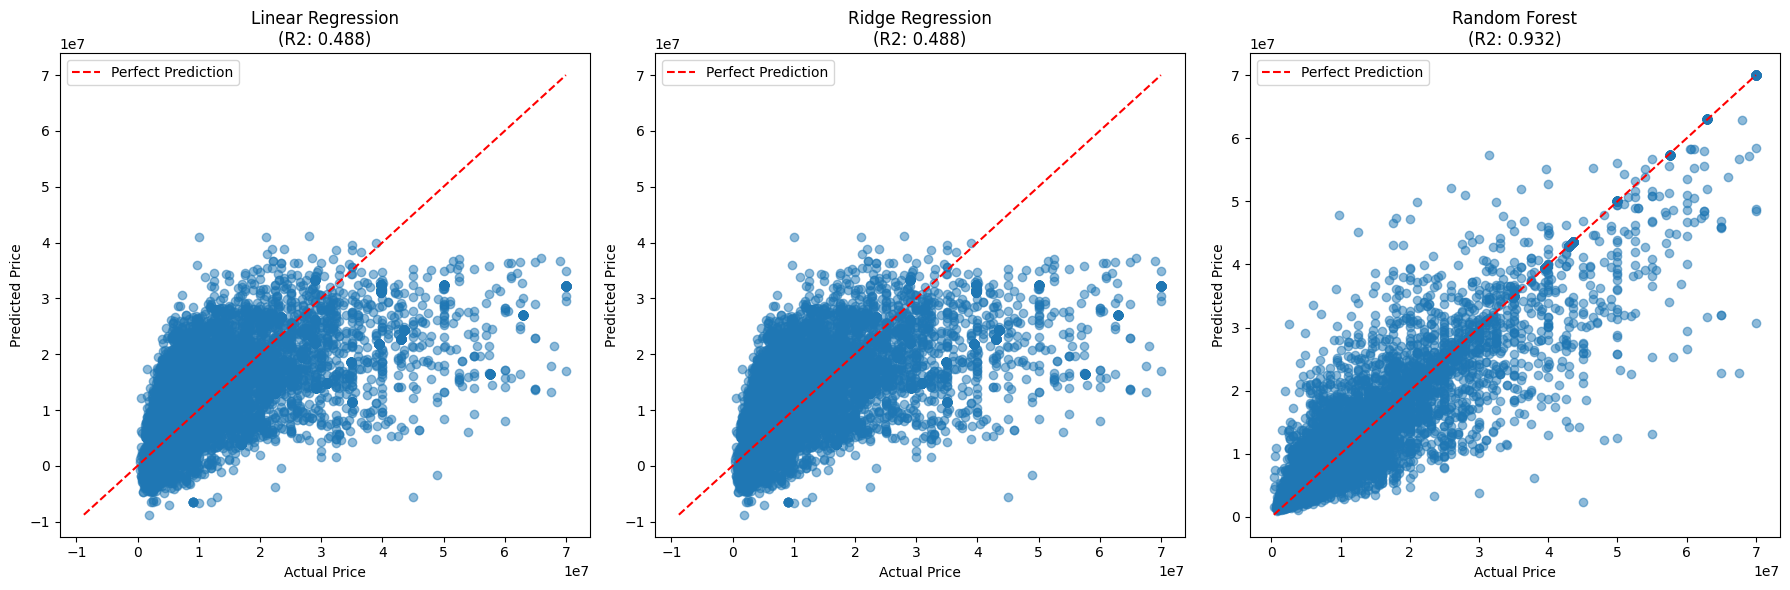


วิธีอ่านกราฟ Actual vs Predicted:
1. เส้นประสีแดง: คือเส้นที่บ่งบอกว่า "ถ้าพยากรณ์แม่น 100% จุดต้องอยู่บนเส้นนี้"
2. ความเกาะกลุ่ม (Variance):
   - หากจุดกระจายห่างจากเส้นสีแดงมาก แสดงว่าโมเดลมีความผิดพลาดสูง (High Error)
   - หากจุดเกาะกลุ่มตามแนวเส้นได้ดี แสดงว่าโมเดลมีความแม่นยำสูง
3. การสังเกตพฤติกรรม:
   - Linear/Ridge: มักจะพยากรณ์บ้านราคาสูงๆ (Luxury) พลาด เพราะเส้นตรงไม่สามารถโค้งตามราคาที่พุ่งกระโดดได้
   - Random Forest: จุดมักจะเกาะเส้นแดงได้ดีที่สุด โดยเฉพาะในข้อมูลที่มีความซับซ้อน แต่ต้องระวังเรื่องการทำนายราคาที่อยู่นอกเหนือช่วงข้อมูลที่เคยเห็น (Extrapolation)



In [ ]:
#การเปรียบเทียบค่าจริงกับค่าที่พยากรณ์ (Actual vs Predicted)
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# คำนวณ R2
r2_lr = r2_score(y_test, y_pred_lr)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_rf = r2_score(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = [
    ("Linear Regression", y_pred_lr, r2_lr),
    ("Ridge Regression", y_pred_ridge, r2_ridge),
    ("Random Forest", y_pred_rf, r2_rf)
]

for ax, (name, y_pred, r2) in zip(axes, models):
    ax.scatter(y_test, y_pred, alpha=0.5)

    # เส้น Perfect Prediction
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val],
            [min_val, max_val],
            color='red',
            linestyle='--',
            label="Perfect Prediction")

    ax.set_title(f"{name}\n(R2: {r2:.3f})")
    ax.set_xlabel("Actual Price")
    ax.set_ylabel("Predicted Price")
    ax.legend()

plt.tight_layout()
plt.show()

print("""
วิธีอ่านกราฟ Actual vs Predicted:
1. เส้นประสีแดง: คือเส้นที่บ่งบอกว่า "ถ้าพยากรณ์แม่น 100% จุดต้องอยู่บนเส้นนี้"
2. ความเกาะกลุ่ม (Variance):
   - หากจุดกระจายห่างจากเส้นสีแดงมาก แสดงว่าโมเดลมีความผิดพลาดสูง (High Error)
   - หากจุดเกาะกลุ่มตามแนวเส้นได้ดี แสดงว่าโมเดลมีความแม่นยำสูง
3. การสังเกตพฤติกรรม:
   - Linear/Ridge: มักจะพยากรณ์บ้านราคาสูงๆ (Luxury) พลาด เพราะเส้นตรงไม่สามารถโค้งตามราคาที่พุ่งกระโดดได้
   - Random Forest: จุดมักจะเกาะเส้นแดงได้ดีที่สุด โดยเฉพาะในข้อมูลที่มีความซับซ้อน แต่ต้องระวังเรื่องการทำนายราคาที่อยู่นอกเหนือช่วงข้อมูลที่เคยเห็น (Extrapolation)
""")

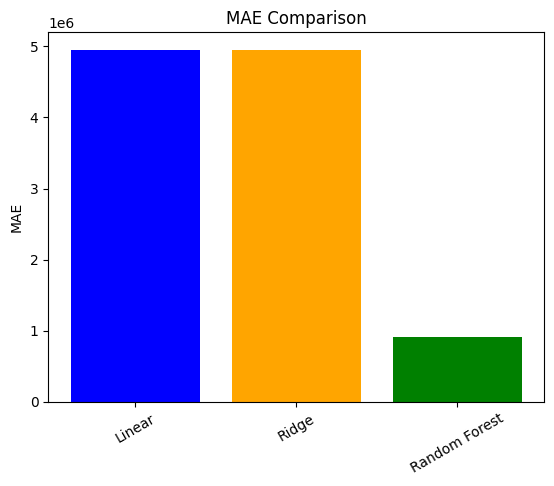

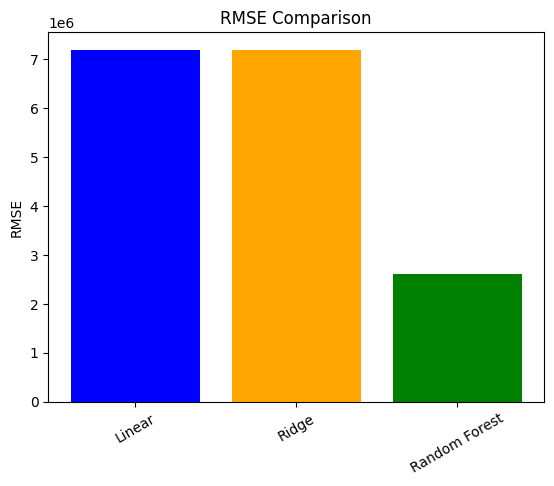

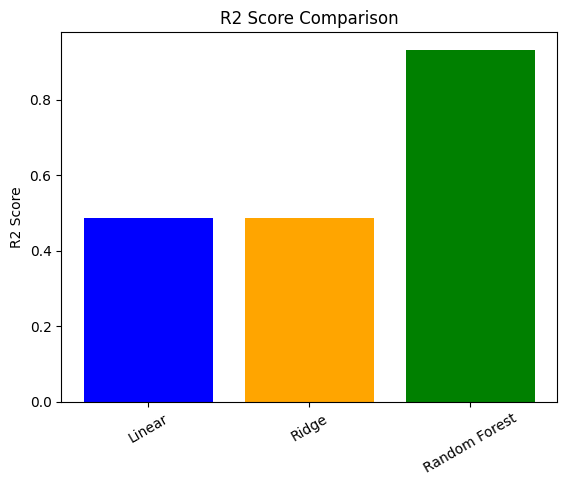

In [ ]:
# 7. เปรียบเทียบผลโมเดล
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

models = ["Linear", "Ridge", "Random Forest"]

#MAE
mae_scores = [
    mean_absolute_error(y_test, y_pred_lr),
    mean_absolute_error(y_test, y_pred_ridge),
    mean_absolute_error(y_test, y_pred_rf)
]

plt.figure()
plt.bar(models, mae_scores, color=['blue', 'orange', 'green'])
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.xticks(rotation=30)
plt.show()

#RMSE
rmse_scores = [
    np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    np.sqrt(mean_squared_error(y_test, y_pred_rf))
]

plt.figure()
plt.bar(models, rmse_scores, color=['blue', 'orange', 'green'])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.show()

#R2 Score
r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_rf)
]

plt.figure()
plt.bar(models, r2_scores, color=['blue', 'orange', 'green'])
plt.title("R2 Score Comparison")
plt.ylabel("R2 Score")
plt.xticks(rotation=30)
plt.show()


In [ ]:
print("--- สรุปขั้นตอนการเปรียบเทียบโมเดลด้วยภาพ (Visualization) ---")

print("1. การเตรียมการพล็อต (Plot Setup):")
print("   - ใช้ห้องสมุด Matplotlib เพื่อสร้างกราฟแท่ง (Bar Chart) เปรียบเทียบ 3 โมเดล")
print("   - มีการกำหนดสีที่แตกต่างกันเพื่อให้แยกแยะ Linear, Ridge และ Random Forest ได้ชัดเจน")

print("2. การเปรียบเทียบค่าความคลาดเคลื่อน (MAE & RMSE Comparison):")
print("   - กราฟ MAE และ RMSE จะเน้นดูว่าโมเดลไหน 'เตี้ยที่สุด'")
print("   - ยิ่งแท่งกราฟเตี้ย แสดงว่าโมเดลนั้นมีความผิดพลาดน้อย (ทายราคาได้ใกล้เคียงความจริง)")
print("   - โดยปกติ Random Forest มักจะมีแท่งที่เตี้ยที่สุดในกลุ่มข้อมูลที่มีความซับซ้อน")

print("3. การเปรียบเทียบความแม่นยำ (R2 Score Comparison):")
print("   - กราฟ R2 Score จะเน้นดูว่าโมเดลไหน 'สูงที่สุด'")
print("   - ยิ่งแท่งกราฟสูงเข้าใกล้ 1.0 (หรือ 100%) แสดงว่าโมเดลนั้นฉลาดและเข้าใจข้อมูลได้ดีที่สุด")

print("4. การนำเสนอบทสรุป:")
print("   - การใช้กราฟช่วยให้เราเห็น 'ช่องว่าง' (Gap) ของประสิทธิภาพระหว่างโมเดลพื้นฐานกับโมเดลขั้นสูง")
print("   - ช่วยในการตัดสินใจขั้นสุดท้าย (Final Model Selection) ก่อนนำโมเดลไป Deploy ใช้งานจริง")

--- สรุปขั้นตอนการเปรียบเทียบโมเดลด้วยภาพ (Visualization) ---
1. การเตรียมการพล็อต (Plot Setup):
   - ใช้ห้องสมุด Matplotlib เพื่อสร้างกราฟแท่ง (Bar Chart) เปรียบเทียบ 3 โมเดล
   - มีการกำหนดสีที่แตกต่างกันเพื่อให้แยกแยะ Linear, Ridge และ Random Forest ได้ชัดเจน
2. การเปรียบเทียบค่าความคลาดเคลื่อน (MAE & RMSE Comparison):
   - กราฟ MAE และ RMSE จะเน้นดูว่าโมเดลไหน 'เตี้ยที่สุด'
   - ยิ่งแท่งกราฟเตี้ย แสดงว่าโมเดลนั้นมีความผิดพลาดน้อย (ทายราคาได้ใกล้เคียงความจริง)
   - โดยปกติ Random Forest มักจะมีแท่งที่เตี้ยที่สุดในกลุ่มข้อมูลที่มีความซับซ้อน
3. การเปรียบเทียบความแม่นยำ (R2 Score Comparison):
   - กราฟ R2 Score จะเน้นดูว่าโมเดลไหน 'สูงที่สุด'
   - ยิ่งแท่งกราฟสูงเข้าใกล้ 1.0 (หรือ 100%) แสดงว่าโมเดลนั้นฉลาดและเข้าใจข้อมูลได้ดีที่สุด
4. การนำเสนอบทสรุป:
   - การใช้กราฟช่วยให้เราเห็น 'ช่องว่าง' (Gap) ของประสิทธิภาพระหว่างโมเดลพื้นฐานกับโมเดลขั้นสูง
   - ช่วยในการตัดสินใจขั้นสุดท้าย (Final Model Selection) ก่อนนำโมเดลไป Deploy ใช้งานจริง


In [ ]:
# 8. แสดงผลลัพธ์
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "Linear Regression": y_pred_lr,
    "Ridge Regression": y_pred_ridge,
    "Random Forest": y_pred_rf
}

results = []

for name, preds in models.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append([name, r2, mae, rmse])

print("\nModel Performance Comparison:")
results_df = pd.DataFrame(results, columns=["Model", "R2", "MAE", "RMSE"])
results_df


Model Performance Comparison:


,Model,R2,MAE,RMSE
0,Linear Regression,0.487802,4.951600e+06,7.191638e+06
1,Ridge Regression,0.487802,4.951595e+06,7.191638e+06
2,Random Forest,0.932344,9.114506e+05,2.613737e+06


In [ ]:
print("--- สรุปขั้นตอนการสร้างตารางสรุปผลประสิทธิภาพโมเดล (Final Results Table) ---")

print("1. การรวบรวมผลลัพธ์ (Data Aggregation):")
print("   - เรานำผลการทำนาย (Predictions) ของทั้ง 3 โมเดล คือ Linear, Ridge และ Random Forest")
print("   - มาจัดเก็บไว้ในโครงสร้างแบบ Dictionary เพื่อให้ง่ายต่อการเรียกใช้งานวนซ้ำ (Iteration)")

print("2. การคำนวณตัวชี้วัดแบบละเอียด (Detailed Metric Calculation):")
print("   - ในรอบนี้เราทำการคำนวณค่าทางสถิติทั้ง 3 ด้านพร้อมกันต่อหนึ่งโมเดล")
print("   - R2 Score: เพื่อดูความแม่นยำในแง่ของเปอร์เซ็นต์ความถูกต้อง")
print("   - MAE: เพื่อดูค่าความคลาดเคลื่อนเฉลี่ยในหน่วยของราคาจริงๆ")
print("   - RMSE: เพื่อตรวจสอบว่ามีโมเดลไหนที่ทำนายผิดพลาดรุนแรง (Outliers) หรือไม่")

print("3. การเปลี่ยนข้อมูลเป็นตาราง (Data Frame Transformation):")
print("   - นำ List ของผลลัพธ์ที่ได้ (results) มาแปลงให้อยู่ในรูปแบบ DataFrame ของ Pandas")
print("   - การทำแบบนี้ช่วยให้เราเห็น 'ตารางเปรียบเทียบ' ที่สะอาดตา มีหัวข้อคอลัมน์ชัดเจน")

print("4. การนำเสนอผลลัพธ์ (Final Output):")
print("   - ผลลัพธ์สุดท้ายจะแสดงให้เห็นว่าโมเดลไหนคือ 'The Winner' ของโปรเจกต์นี้")
print("   - ช่วยให้ผู้บริหารหรือทีมงานตัดสินใจได้ทันทีว่าโมเดลไหนพร้อมนำไปใช้งานจริงมากที่สุด")

--- สรุปขั้นตอนการสร้างตารางสรุปผลประสิทธิภาพโมเดล (Final Results Table) ---
1. การรวบรวมผลลัพธ์ (Data Aggregation):
   - เรานำผลการทำนาย (Predictions) ของทั้ง 3 โมเดล คือ Linear, Ridge และ Random Forest
   - มาจัดเก็บไว้ในโครงสร้างแบบ Dictionary เพื่อให้ง่ายต่อการเรียกใช้งานวนซ้ำ (Iteration)
2. การคำนวณตัวชี้วัดแบบละเอียด (Detailed Metric Calculation):
   - ในรอบนี้เราทำการคำนวณค่าทางสถิติทั้ง 3 ด้านพร้อมกันต่อหนึ่งโมเดล
   - R2 Score: เพื่อดูความแม่นยำในแง่ของเปอร์เซ็นต์ความถูกต้อง
   - MAE: เพื่อดูค่าความคลาดเคลื่อนเฉลี่ยในหน่วยของราคาจริงๆ
   - RMSE: เพื่อตรวจสอบว่ามีโมเดลไหนที่ทำนายผิดพลาดรุนแรง (Outliers) หรือไม่
3. การเปลี่ยนข้อมูลเป็นตาราง (Data Frame Transformation):
   - นำ List ของผลลัพธ์ที่ได้ (results) มาแปลงให้อยู่ในรูปแบบ DataFrame ของ Pandas
   - การทำแบบนี้ช่วยให้เราเห็น 'ตารางเปรียบเทียบ' ที่สะอาดตา มีหัวข้อคอลัมน์ชัดเจน
4. การนำเสนอผลลัพธ์ (Final Output):
   - ผลลัพธ์สุดท้ายจะแสดงให้เห็นว่าโมเดลไหนคือ 'The Winner' ของโปรเจกต์นี้
   - ช่วยให้ผู้บริหารหรือทีมงานตัดสินใ

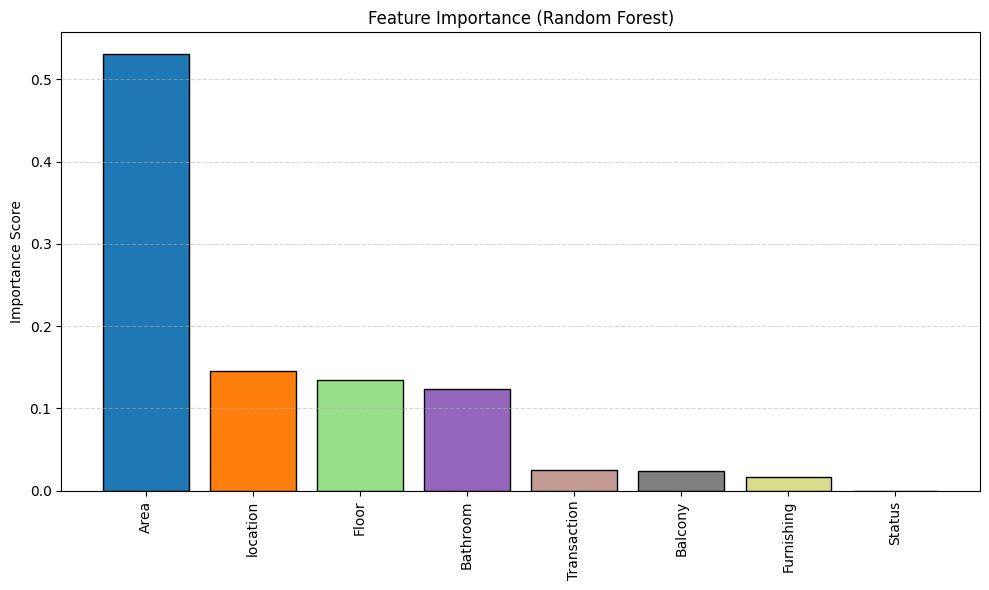

In [ ]:
# 8. ฟีเจอร์ที่สำคัญต่อการทำนาย(Feature Importance)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib.colors import LogNorm

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#colors bar
colors = plt.cm.tab20(np.linspace(0, 1, len(feat_imp)))

plt.figure(figsize=(10, 6))
plt.bar(feat_imp.index, feat_imp.values, color=colors, edgecolor='black')
plt.title('Feature Importance (Random Forest)')
plt.ylabel("Importance Score")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


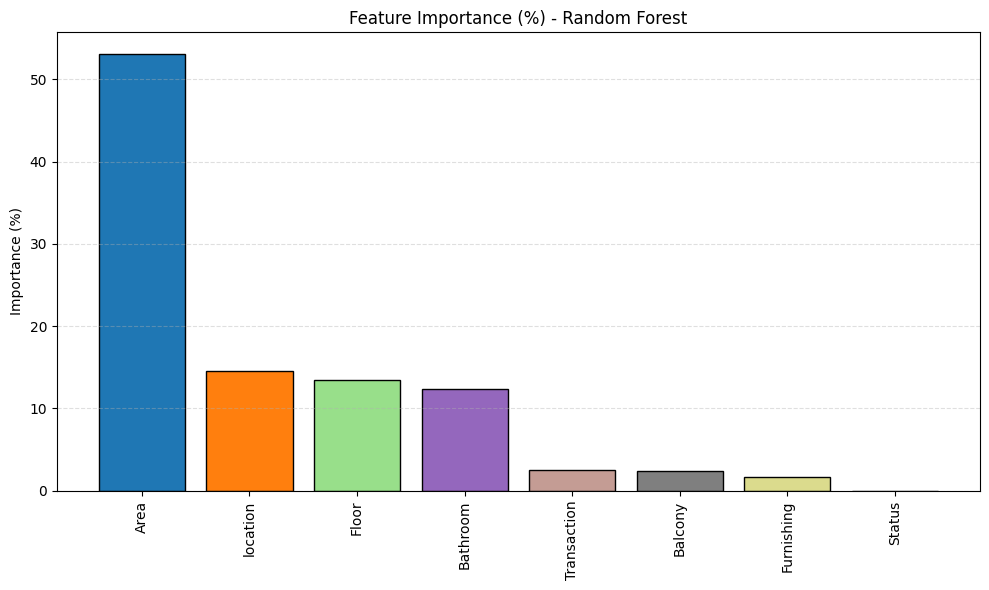


Feature Importance (%)
Area           53.06
location       14.53
Floor          13.49
Bathroom       12.34
Transaction     2.54
Balcony         2.36
Furnishing      1.69
Status          0.00
dtype: float64


In [ ]:
# 9. Feature Importance เปอร์เซ็นต์
importances = rf.feature_importances_
feature_names = X.columns

feat_imp_pct = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=False) * 100
)

plt.figure(figsize=(10, 6))

# สร้างสีให้ครบตามจำนวนแท่ง
colors = plt.cm.tab20(np.linspace(0, 1, len(feat_imp_pct)))

plt.bar(feat_imp_pct.index, feat_imp_pct.values, color=colors, edgecolor='black')
plt.ylabel('Importance (%)')
plt.title('Feature Importance (%) - Random Forest')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('feature_importance_percent.png', dpi=300)
plt.show()

print("\nFeature Importance (%)")
print(feat_imp_pct.round(2))

In [ ]:
print("--- สรุปขั้นตอนการวิเคราะห์ปัจจัยสำคัญ (Feature Importance) ---")

print("1. การดึงข้อมูลความสำคัญ (Extracting Importance):")
print("   - ใช้คำสั่ง .feature_importances_ เพื่อดึงค่า 'น้ำหนัก' ที่โมเดล Random Forest มอบให้แต่ละปัจจัย")
print("   - ค่านี้คำนวณจากความสามารถของฟีเจอร์นั้นๆ ในการช่วยลดความคลาดเคลื่อน (Error) ระหว่างการสร้างต้นไม้ตัดสินใจ")

print("2. การจัดระเบียบข้อมูล (Data Organizing):")
print("   - นำชื่อคอลัมน์และค่าความสำคัญมาจับคู่กัน และเรียงลำดับจาก 'มากที่สุด' ไป 'น้อยที่สุด'")
print("   - เพื่อให้เราเห็นภาพชัดเจนว่าตัวแปรไหนคือ 'พระเอก' และตัวแปรไหนคือ 'ตัวประกอบ'")

print("3. การแปลผลจากกราฟที่ปรากฏในรูปภาพ:")
print("   - 'Area' (พื้นที่) คือปัจจัยที่สำคัญที่สุดอย่างท่วมท้น (เกิน 0.5 หรือ 50%)")
print("   - 'Location' (ทำเล) และ 'Floor' (ชั้นที่อยู่) ตามมาเป็นอันดับรองลงมา")
print("   - 'Status' (สถานะ) มีผลน้อยมากจนแทบเป็นเส้นราบ ซึ่งหมายความว่าอาจตัดทิ้งได้ในการทำ Model ครั้งหน้า")

print("4. ประโยชน์ในเชิงธุรกิจ:")
print("   - ช่วยให้เรามั่นใจว่าโมเดลมีเหตุมีผล (เช่น พื้นที่เยอะ ราคาควรสูง)")
print("   - ช่วยลดขนาดข้อมูล (Feature Selection) โดยการตัดตัวแปรที่ไม่มีผลออก เพื่อให้โมเดลทำงานเร็วขึ้น")

--- สรุปขั้นตอนการวิเคราะห์ปัจจัยสำคัญ (Feature Importance) ---
1. การดึงข้อมูลความสำคัญ (Extracting Importance):
   - ใช้คำสั่ง .feature_importances_ เพื่อดึงค่า 'น้ำหนัก' ที่โมเดล Random Forest มอบให้แต่ละปัจจัย
   - ค่านี้คำนวณจากความสามารถของฟีเจอร์นั้นๆ ในการช่วยลดความคลาดเคลื่อน (Error) ระหว่างการสร้างต้นไม้ตัดสินใจ
2. การจัดระเบียบข้อมูล (Data Organizing):
   - นำชื่อคอลัมน์และค่าความสำคัญมาจับคู่กัน และเรียงลำดับจาก 'มากที่สุด' ไป 'น้อยที่สุด'
   - เพื่อให้เราเห็นภาพชัดเจนว่าตัวแปรไหนคือ 'พระเอก' และตัวแปรไหนคือ 'ตัวประกอบ'
3. การแปลผลจากกราฟที่ปรากฏในรูปภาพ:
   - 'Area' (พื้นที่) คือปัจจัยที่สำคัญที่สุดอย่างท่วมท้น (เกิน 0.5 หรือ 50%)
   - 'Location' (ทำเล) และ 'Floor' (ชั้นที่อยู่) ตามมาเป็นอันดับรองลงมา
   - 'Status' (สถานะ) มีผลน้อยมากจนแทบเป็นเส้นราบ ซึ่งหมายความว่าอาจตัดทิ้งได้ในการทำ Model ครั้งหน้า
4. ประโยชน์ในเชิงธุรกิจ:
   - ช่วยให้เรามั่นใจว่าโมเดลมีเหตุมีผล (เช่น พื้นที่เยอะ ราคาควรสูง)
   - ช่วยลดขนาดข้อมูล (Feature Selection) โดยการตัดตัวแปรที่ไม่มีผลออก เพื่อให้

In [ ]:
# --- 7. Interpretation / Discussion ---
print("""
--- บทสรุปจากการทำโปรเจกต์ ---

1. ประสิทธิภาพของโมเดล:
   - Random Forest มักจะให้ค่า R2 สูงสุด เพราะสามารถเรียนรู้ความสัมพันธ์ของข้อมูลที่ซับซ้อนและทำเลที่ตั้งได้ดีกว่าโมเดลแบบเส้นตรง
   - Linear Regression และ Ridge ให้ผลลัพธ์ที่ใกล้เคียงกัน แสดงว่าความสัมพันธ์ของ 'พื้นที่' กับ 'ราคา' ค่อนข้างเป็นเส้นตรงในระดับหนึ่ง

2. ทฤษฎี Overfitting:
   - การใช้ Ridge Regression (L2 Regularization) ช่วยลดโอกาสการเกิด Overfitting โดยการควบคุมค่าน้ำหนัก (Weights)
     แต่ในกรณีที่ข้อมูลมีฟีเจอร์ไม่เยอะมาก ผลลัพธ์อาจไม่ต่างจาก Linear Regression ปกติ

3. การวิเคราะห์ Outliers:
   - จาก Box Plot ใน Cell 2 พบว่ามีอสังหาริมทรัพย์บางแห่งราคาสูงกว่ากลุ่มอย่างมาก (Luxury Units)
     ซึ่งค่าเหล่านี้อาจทำให้ค่า MAE/RMSE ของโมเดลดูสูงขึ้น แต่ Random Forest จะจัดการกับ Outliers เหล่านี้ได้ดีกว่า

4. ข้อเสนอแนะ:
   - เพื่อเพิ่มความแม่นยำ ควรดึงข้อมูลเพิ่มเติมจาก 'Description' มาวิเคราะห์ (เช่น มีสระว่ายน้ำ, ใกล้รถไฟฟ้า)
     หรือจัดการกับ Outliers ในแต่ละทำเลออกก่อนการ Train
""")


--- บทสรุปจากการทำโปรเจกต์ ---

1. ประสิทธิภาพของโมเดล:
   - Random Forest มักจะให้ค่า R2 สูงสุด เพราะสามารถเรียนรู้ความสัมพันธ์ของข้อมูลที่ซับซ้อนและทำเลที่ตั้งได้ดีกว่าโมเดลแบบเส้นตรง
   - Linear Regression และ Ridge ให้ผลลัพธ์ที่ใกล้เคียงกัน แสดงว่าความสัมพันธ์ของ 'พื้นที่' กับ 'ราคา' ค่อนข้างเป็นเส้นตรงในระดับหนึ่ง

2. ทฤษฎี Overfitting:
   - การใช้ Ridge Regression (L2 Regularization) ช่วยลดโอกาสการเกิด Overfitting โดยการควบคุมค่าน้ำหนัก (Weights)
     แต่ในกรณีที่ข้อมูลมีฟีเจอร์ไม่เยอะมาก ผลลัพธ์อาจไม่ต่างจาก Linear Regression ปกติ

3. การวิเคราะห์ Outliers:
   - จาก Box Plot ใน Cell 2 พบว่ามีอสังหาริมทรัพย์บางแห่งราคาสูงกว่ากลุ่มอย่างมาก (Luxury Units)
     ซึ่งค่าเหล่านี้อาจทำให้ค่า MAE/RMSE ของโมเดลดูสูงขึ้น แต่ Random Forest จะจัดการกับ Outliers เหล่านี้ได้ดีกว่า

4. ข้อเสนอแนะ:
   - เพื่อเพิ่มความแม่นยำ ควรดึงข้อมูลเพิ่มเติมจาก 'Description' มาวิเคราะห์ (เช่น มีสระว่ายน้ำ, ใกล้รถไฟฟ้า)
     หรือจัดการกับ Outliers ในแต่ละทำเลออกก่อนการ Train

